In [1]:
# Load the necessary libraries
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json
from datetime import datetime
from IPython.core.debugger import Pdb # I encourage you to use the degubber, rather than print statements!

In [2]:
# Load the MNIST dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

# Get the data into easy to use arrays
train_images = train_set[0].transpose()
train_labels = np.zeros((10,train_images.shape[1]))
for label in range(train_labels.shape[1]):
    train_labels[train_set[1][label],label] = 1
test_images = test_set[0].transpose()
test_labels = np.zeros((10,test_images.shape[1]))
for label in range(test_labels.shape[1]):
    test_labels[test_set[1][label],label] = 1

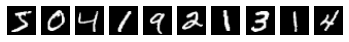

In [3]:
#Plot some example images to make sure everything is loaded in properly
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(train_images[:,c].reshape((28,28)), cmap='gray')
    axs[c].axis("off")
plt.show()

In [4]:
##############################################################################################
# Some helper functions

# The sigmoid function
def sigmoid(X):
    """
    Returns the sigmoid function, i.e. 1/(1+exp(-X))
    """
    
    # to avoid runtime warnings, if abs(X) is more than 500, let's just cap it there
    toobig   = X > 500
    toosmall = X < -500
    X[toobig]   = 500
    X[toosmall] = -500
        
    return 1.0/(1.0 + np.exp(-X))
 
# A helper function to add an "always on" bias units to the inputs
def add_bias(inputs):
    """
    Append an "always on" bias to some inputs
    """
    return np.append(inputs,np.ones((1,inputs.shape[1])),axis=0)

# Creates a random set of batches, returns an array of indices, one for each batch
def create_batches(batch_size, num_samples):
    """
    For a given number of samples, returns an array of indices of random batches of the specified size.
    
    If the size of the data is not divisible by the batch size some samples will not be included.
    """
    
    # determine the total number of batches
    num_batches = int(np.floor(num_samples/batch_size))
    
    # get the batches (without replacement)
    return np.random.choice(np.arange(num_samples),size=(num_batches,batch_size),replace=False)

# Calculate the accuracy of the network on some data
def calculate_accuracy(outputs,targets):
    """
    Calculate the accuracy in categorization of some outputs given some targets.
    """
    
    # binarize the outputs for an easy calculation
    categories = (outputs == np.tile(outputs.max(axis=0),(10,1))).astype('float')
    
    # get the accuracy
    accuracy = np.sum(categories*targets)/targets.shape[1]
    
    return accuracy*100.0

In [5]:
##############################################################################################
# The main network class
class MLP(object):
    """
    The class for creating and training a two-layer perceptron.
    """
    
    # The initialization function
    def __init__(self,N,B,eta,alpha=1.0,sigma=1.0,algorithm='backprop'):
        """
        The initialization function for the MLP.
        
         - N is the number of hidden units
         - B is the batch size
         - eta is the learning rate
         - alpha is the SD for initializing the weights
         - sigma is the SD for weight perturbation functions
         - algorithm is a string indicating which learning algorithm to use, 
           options are ('backprop','perturb','feedback','kolepoll'), will default to backprop
        """ 
                      
        # store the variables for easy access
        self.N     = N
        self.B     = B
        self.eta   = eta
        self.alpha = alpha
        self.sigma = sigma
        self.algorithm = algorithm
        
        # initialize the weights
        self.W_h = random.normal(scale=self.alpha,size=(self.N,784+1)) # input-to-hidden weights & bias
        self.W_y = random.normal(scale=self.alpha,size=(10,self.N+1))  # hidden-to-output weights & bias
        self.V   = random.normal(scale=self.alpha,size=(self.N,10))    # feedback weights
        
    # The function for performing a forward pass up through the network during inference
    def inference(self,inputs,W_h=None,W_y=None):
        """
        Recognize inputs, i.e. do a forward pass up through the network. If desired, alternative weights
        can be provided
        """
        
        # load the current weights if no weights given
        if W_h is None:
            W_h = self.W_h
        if W_y is None:
            W_y = self.W_y
            
        # calculate the hidden activities
        hidden = sigmoid(np.dot(W_h,add_bias(inputs))) 
                              
        # calculate the output activities
        output = sigmoid(np.dot(W_y,add_bias(hidden)))
                      
        return (hidden,output)
                           
    # the function for calculating the loss
    def loss(self,inputs,targets,W_h=None,W_y=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """
                      
        # do a forward sweep through the network
        (hidden,output) = self.inference(inputs,W_h,W_y)
                      
        return np.mean(np.sum((targets - output)**2,axis=0))
    
    # function for calculating perturbation updates
    def perturb(self,inputs,targets):
        """
        Calculates the weight updates for perturbation learning
        """
        
        # do a forward pass
        (hidden,output) = self.inference(inputs)
        
        # get the random perturbations - CHANGE THESE LINES
        delta_W_h = np.zeros(self.W_h.shape)
        delta_W_y = np.zeros(self.W_y.shape)
                         
        return (delta_W_h,delta_W_y)
                         
    # function for calculating gradient updates
    def gradient(self,inputs,targets):
        """
        Calculates the weight updates for gradient descent learning
        """
        
        # do a forward pass
        (hidden,output) = self.inference(inputs)
        
        # calculate the gradients - CHANGE THESE LINES
        delta_W_h = np.zeros(self.W_h.shape)
        delta_W_y = np.zeros(self.W_y.shape)
                           
        return (delta_W_h,delta_W_y)
    
    # function for calculating feedback alignment updates
    def feedback(self,inputs,targets):
        """
        Calculates the weight updates for feedback alignment learning
        """
        
        # do a forward pass
        (hidden,output) = self.inference(inputs)
        
        # calculate the updates - CHANGE THESE LINES
        delta_W_h = np.zeros(self.W_h.shape)
        delta_W_y = np.zeros(self.W_y.shape)
                           
        return (delta_W_h,delta_W_y)
    
    # function for calculating Kolen-Pollack updates
    def kolepoll(self,inputs,targets):
        """
        Calculates the weight updates for Kolen-Polack learning
        """
        
        # do a forward pass
        (hidden,output) = self.inference(inputs)
        
        # calculate the updates for the weights - CHANGE THESE LINES
        delta_W_h = np.zeros(self.W_h.shape)
        delta_W_y = np.zeros(self.W_y.shape)
        delta_V   = np.zeros(self.V.shape)
        
        # update the backwards weights
        self.V += self.eta*delta_V
                           
        return (delta_W_h,delta_W_y)
    
    # function for updating the network
    def update(self,inputs,targets):
                         
        # calculate the updates for the weights with the appropriate algorithm
        if self.algorithm == 'backprop':
            (delta_W_h,delta_W_y) = self.gradient(inputs,targets)
        elif self.algorithm == 'perturb':
            (delta_W_h,delta_W_y) = self.perturb(inputs,targets)
        elif self.algorithm == 'feedback':
            (delta_W_h,delta_W_y) = self.feedback(inputs,targets)
        elif self.algorithm == 'kolepoll':
            (delta_W_h,delta_W_y) = self.kolepoll(inputs,targets)
        else:
            (delta_W_h,delta_W_y) = self.gradient(inputs,targets)
            
        # do the updates
        self.W_h += self.eta*delta_W_h
        self.W_y += self.eta*delta_W_y
    
    # train the network using the update functions
    def train(self,images,labels,num_epochs,test_images,test_labels,report=False,report_rate=10):
        """
        Trains the network in batches for the given number of epochs on the data provided.
        
        Categorization accuracy on a test set is also calculated.
        
        Prints a message every report_rate epochs if requested.
        
        Returns an array of the losses achieved at each epoch (and accuracies if test data given).
        """
        
        # provide an output message
        if report:
            print("Training starting...")
        
        # make batches from the data
        batches = create_batches(self.B,images.shape[1])
        
        # create arrays to store loss and accuracy values
        losses   = np.zeros((num_epochs*self.B,))
        accuracy = np.zeros((num_epochs,))
        
        # run the training for the given number of epochs
        update_counter = 0
        for epoch in range(num_epochs):
            
            # step through each batch
            for b in range(self.B):
                
                # get the inputs and targets for this batch
                inputs  = images[:,batches[b,:]]
                targets = labels[:,batches[b,:]]
                         
                # calculate the current loss
                losses[update_counter] = self.loss(inputs,targets)
                
                # update the weights
                self.update(inputs,targets)
                update_counter += 1
                
            # calculate the current test accuracy
            (testhid,testout) = self.inference(test_images)
            accuracy[epoch]   = calculate_accuracy(testout,test_labels)
                
            # print an output message every 10 epochs
            if report and np.mod(epoch+1,report_rate) == 0:
                print("...completed ", epoch+1, 
                      " epochs of training. Current loss: ",round(losses[update_counter-1],2), ".")
                
        # provide an output message
        if report:
            print("Training complete.")
        
        return (losses,accuracy)

In [6]:
# run parameters
numhidden  = 100
batchsize  = 100
initweight = 0.1
learnrate  = 0.001
numepochs  = 20
numrepeats = 10
numupdates = numepochs*batchsize

# initialize the loss and accuracy holders
losses_perturb  = np.zeros((numupdates,numrepeats))
losses_backprop = np.zeros((numupdates,numrepeats))
losses_feedback = np.zeros((numupdates,numrepeats))
losses_kolepoll = np.zeros((numupdates,numrepeats))
accuracy_perturb  = np.zeros((numepochs,numrepeats))
accuracy_backprop = np.zeros((numepochs,numrepeats))
accuracy_feedback = np.zeros((numepochs,numrepeats))
accuracy_kolepoll = np.zeros((numepochs,numrepeats))

# for each repeat, pick a new random seed, train, and store the losses and accuracies on 100 random test images
for r in range(numrepeats):
    
    # set the random seed to the current time
    seed = int(round(datetime.now().timestamp())) + r
    random.seed(seed)
    np.random.seed(seed)
    
    # select 100 random images to test the accuracy on
    indices = random.choice(range(test_images.shape[1]),size=(100,),replace=False)
    
    # create a network and train it using weight perturbation
    netperturb = MLP(numhidden,batchsize,learnrate,alpha=initweight,algorithm='perturb',sigma=10)
    (losses_perturb[:,r],accuracy_perturb[:,r]) = \
    netperturb.train(train_images,train_labels,numepochs,test_images[:,indices],test_labels[:,indices])

    # create a network and train it using backprop
    netbackprop = MLP(numhidden,batchsize,learnrate,alpha=initweight,algorithm='backprop')
    (losses_backprop[:,r],accuracy_backprop[:,r]) = \
    netbackprop.train(train_images,train_labels,numepochs,test_images[:,indices],test_labels[:,indices])

    # create a network and train it using feedback alignment
    netfeedback = MLP(numhidden,batchsize,learnrate,alpha=initweight,algorithm='feedback')
    (losses_feedback[:,r],accuracy_feedback[:,r]) = \
    netfeedback.train(train_images,train_labels,numepochs,test_images[:,indices],test_labels[:,indices])
    
    # create a network and train it using Kolen-Pollack
    netkolepoll = MLP(numhidden,batchsize,learnrate,alpha=initweight,algorithm='feedback')
    (losses_kolepoll[:,r],accuracy_kolepoll[:,r]) = \
    netkolepoll.train(train_images,train_labels,numepochs,test_images[:,indices],test_labels[:,indices])

# calculate the means and standard deviations
avg_loss_perturb = np.mean(losses_perturb,axis=1)
std_loss_perturb = np.std(losses_perturb,axis=1)
avg_loss_backprop = np.mean(losses_backprop,axis=1)
std_loss_backprop = np.std(losses_backprop,axis=1)
avg_loss_feedback = np.mean(losses_feedback,axis=1)
std_loss_feedback = np.std(losses_feedback,axis=1)
avg_loss_kolepoll = np.mean(losses_kolepoll,axis=1)
std_loss_kolepoll = np.std(losses_kolepoll,axis=1)
avg_acc_perturb = np.mean(accuracy_perturb,axis=1)
std_acc_perturb = np.std(accuracy_perturb,axis=1)
avg_acc_backprop = np.mean(accuracy_backprop,axis=1)
std_acc_backprop = np.std(accuracy_backprop,axis=1)
avg_acc_feedback = np.mean(accuracy_feedback,axis=1)
std_acc_feedback = np.std(accuracy_feedback,axis=1)
avg_acc_kolepoll = np.mean(accuracy_kolepoll,axis=1)
std_acc_kolepoll = np.std(accuracy_kolepoll,axis=1)

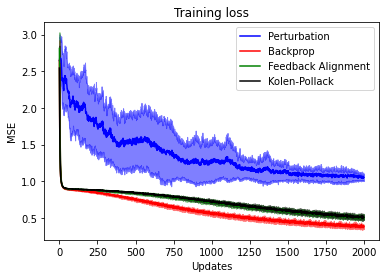

In [237]:
# Plot the losses over training with shaded error regions
plt.plot(avg_loss_perturb,label="Perturbation",color='b')
plt.fill_between(range(numupdates),avg_loss_perturb-std_loss_perturb,avg_loss_perturb+std_loss_perturb,color='b',alpha=0.5)
plt.plot(avg_loss_backprop,label="Backprop",color='r')
plt.fill_between(range(numupdates),avg_loss_backprop-std_loss_backprop,avg_loss_backprop+std_loss_backprop,color='r',alpha=0.5)
plt.plot(avg_loss_feedback,label="Feedback Alignment",color='g')
plt.fill_between(range(numupdates),avg_loss_feedback-std_loss_feedback,avg_loss_feedback+std_loss_feedback,color='g',alpha=0.5)
plt.plot(avg_loss_kolepoll,label="Kolen-Pollack",color='k')
plt.fill_between(range(numupdates),avg_loss_kolepoll-std_loss_kolepoll,avg_loss_kolepoll+std_loss_kolepoll,color='k',alpha=0.5)
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()

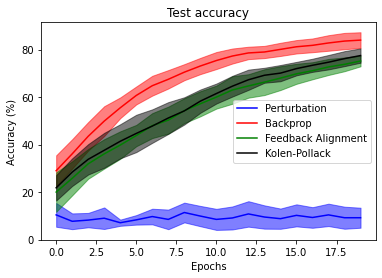

In [238]:
# Plot the accuracies over training with shaded error regions
plt.plot(avg_acc_perturb,label="Perturbation",color='b')
plt.fill_between(range(numepochs),avg_acc_perturb-std_acc_perturb,avg_acc_perturb+std_acc_perturb,color='b',alpha=0.5)
plt.plot(avg_acc_backprop,label="Backprop",color='r')
plt.fill_between(range(numepochs),avg_acc_backprop-std_acc_backprop,avg_acc_backprop+std_acc_backprop,color='r',alpha=0.5)
plt.plot(avg_acc_feedback,label="Feedback Alignment",color='g')
plt.fill_between(range(numepochs),avg_acc_feedback-std_acc_feedback,avg_acc_feedback+std_acc_feedback,color='g',alpha=0.5)
plt.plot(avg_acc_kolepoll,label="Kolen-Pollack",color='k')
plt.fill_between(range(numepochs),avg_acc_kolepoll-std_acc_kolepoll,avg_acc_kolepoll+std_acc_kolepoll,color='k',alpha=0.5)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Test accuracy")
plt.show()